In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pathlib
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from skimage.io import imread
import cv2

In [3]:
print(tf.__version__)

2.10.0


In [4]:
path = 'fruits'
data_dir = pathlib.Path(path)

In [5]:
# get class names

class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['apple' 'orange' 'quava']


In [6]:
# count image
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

89


In [7]:
import random
def view_random_image(target_dir,target_class):
    folder = target_dir+target_class
    random_sample = random.sample(os.listdir(folder),1)
    img = imread(folder + '/' + random_sample[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    return img
    

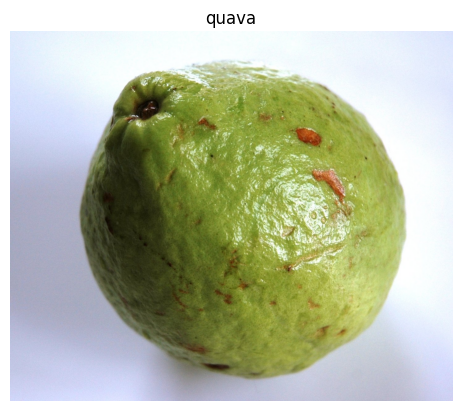

In [19]:
img = view_random_image('fruits'+'/','quava')

In [20]:
img.shape

(1199, 1435, 3)

In [21]:
batch_size=32
height = 180
width = 180


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      validation_split=0.2,subset='training',
                                                      seed=123,image_size=(height,width), batch_size=batch_size)

Found 90 files belonging to 3 classes.
Using 72 files for training.


In [23]:
valid_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,
                                                      subset='validation',
                                                      seed=123,image_size=(height,width),batch_size=batch_size)

Found 90 files belonging to 3 classes.
Using 18 files for validation.


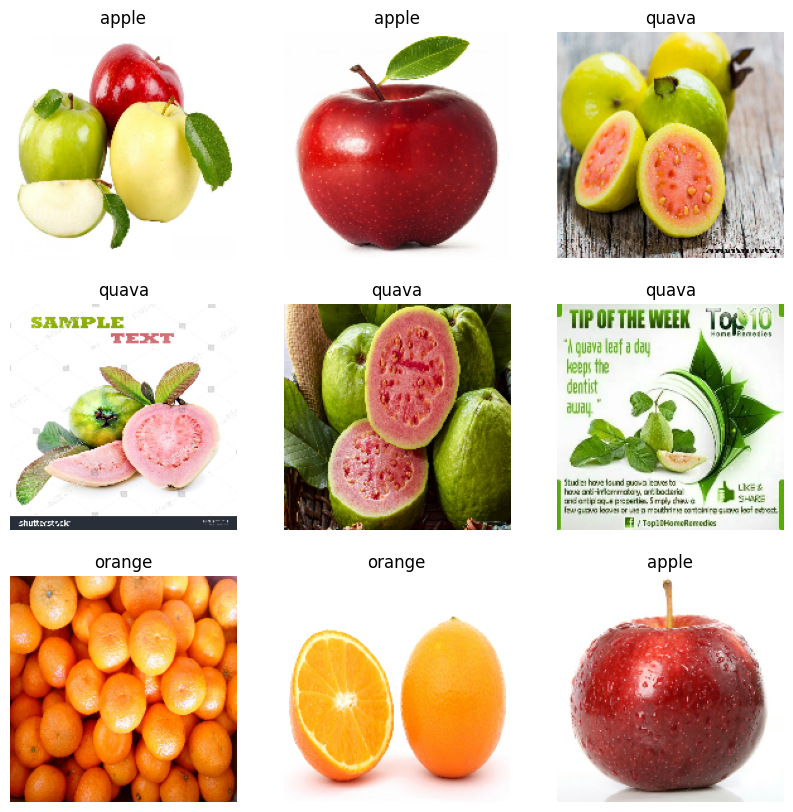

In [24]:
# visualize the data

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for  i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [25]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [27]:
num_classes = len(class_names)
print(num_classes)

3


In [28]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(height, width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 9s 2s/step - loss: 2.0655 - accuracy: 0.3472 - val_loss: 1.8653 - val_accuracy: 0.4444
Epoch 2/10
3/3 [==============================] - 2s 638ms/step - loss: 1.3631 - accuracy: 0.4861 - val_loss: 1.1392 - val_accuracy: 0.3889
Epoch 3/10
3/3 [==============================] - 2s 804ms/step - loss: 0.9583 - accuracy: 0.4861 - val_loss: 0.9534 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 491ms/step - loss: 0.7383 - accuracy: 0.7639 - val_loss: 0.6885 - val_accuracy: 0.8333
Epoch 5/10
3/3 [==============================] - 2s 640ms/step - loss: 0.5132 - accuracy: 0.8472 - val_loss: 0.5480 - val_accuracy: 0.8333
Epoch 6/10
3/3 [==============================] - 2s 443ms/step - loss: 0.3671 - accuracy: 0.8611 - val_loss: 0.4781 - val_accuracy: 0.8889
Epoch 7/10
3/3 [==============================] - 2s 481ms/step - loss: 0.2599 - accuracy: 0.8889 - val_loss: 0.4472 - val_accuracy: 0.8889
Epoch 8/10
3/3 [=======

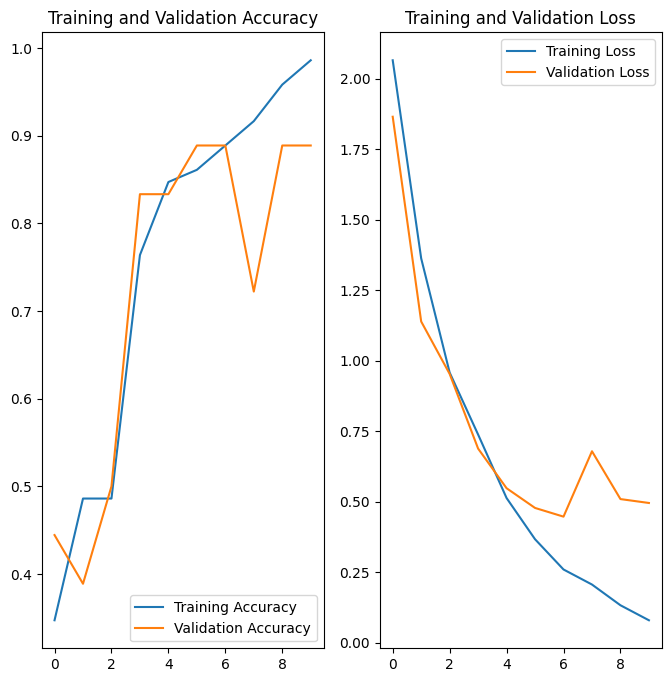

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(height,
                                  width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

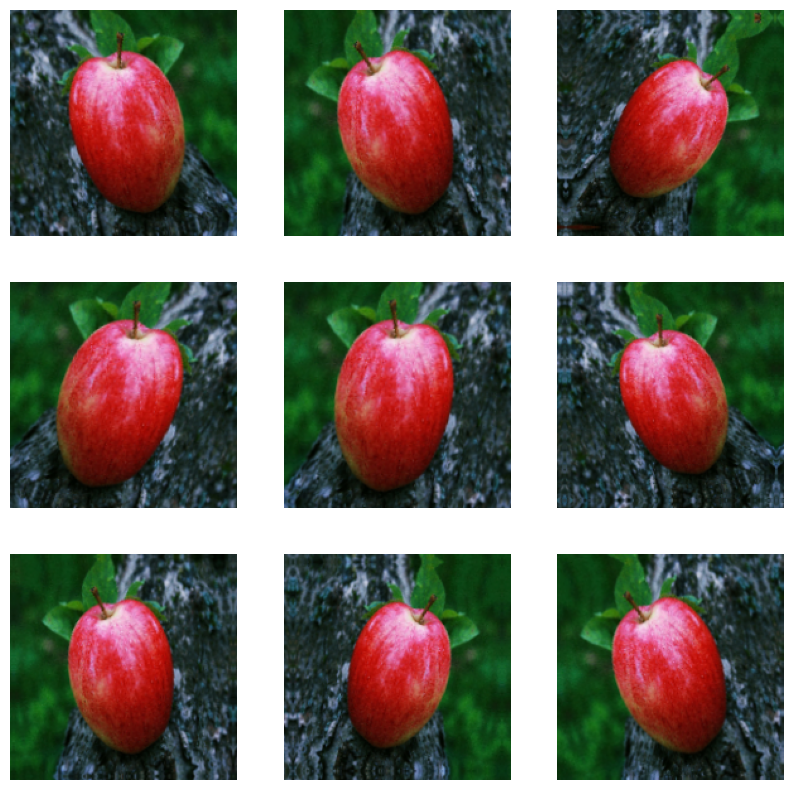

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [37]:
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 15
history_aug = model_aug.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 19s 2s/step - loss: 1.7251 - accuracy: 0.3889 - val_loss: 2.2265 - val_accuracy: 0.1667
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.1778 - accuracy: 0.4167 - val_loss: 0.9879 - val_accuracy: 0.4444
Epoch 3/15
3/3 [==============================] - 2s 618ms/step - loss: 0.9977 - accuracy: 0.5694 - val_loss: 0.9694 - val_accuracy: 0.5556
Epoch 4/15
3/3 [==============================] - 2s 553ms/step - loss: 0.9296 - accuracy: 0.5833 - val_loss: 0.7883 - val_accuracy: 0.7778
Epoch 5/15
3/3 [==============================] - 2s 601ms/step - loss: 0.8104 - accuracy: 0.7083 - val_loss: 0.6590 - val_accuracy: 0.8333
Epoch 6/15
3/3 [==============================] - 2s 599ms/step - loss: 0.6387 - accuracy: 0.7500 - val_loss: 0.4511 - val_accuracy: 0.8889
Epoch 7/15
3/3 [==============================] - 2s 578ms/step - loss: 0.4734 - accuracy: 0.8194 - val_loss: 0.5585 - val_accuracy: 0.8333
Epoch 8/15
3/3 [=========

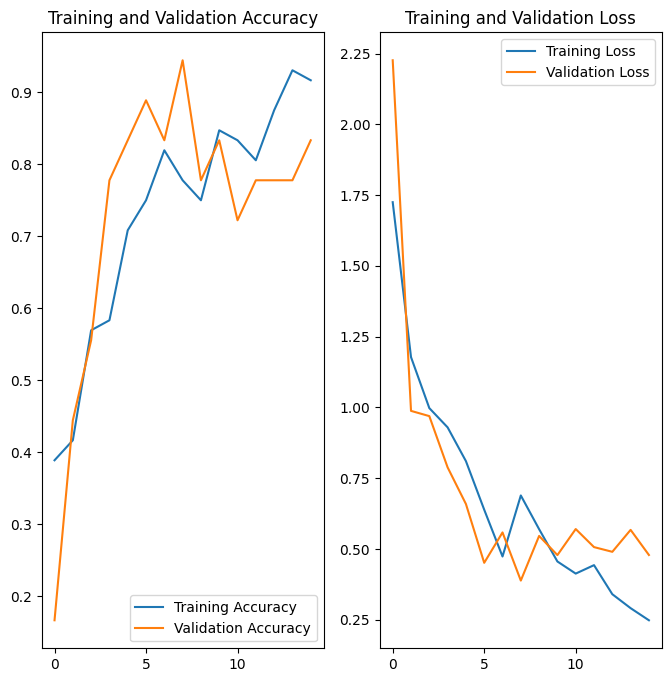

In [39]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
image_path = 'app.jpg'
img = tf.keras.utils.load_img(image_path,target_size=(height,width))

In [41]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [42]:
predictions = model_aug.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 619ms/step
This image most likely belongs to apple with a 94.84 percent confidence.


In [43]:
def predict_image(model,filename):
    img = tf.keras.utils.load_img(filename,target_size=(height,width))
    img_array=tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    plt.imshow(img)
    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])
    plt.title(f"the image belongs to:{class_names[pred.argmax()]} class, with a percent confidence of {100*np.max(score)}")
    
    plt.axis('off')
    
    

1/1 [==============================] - 0s 96ms/step


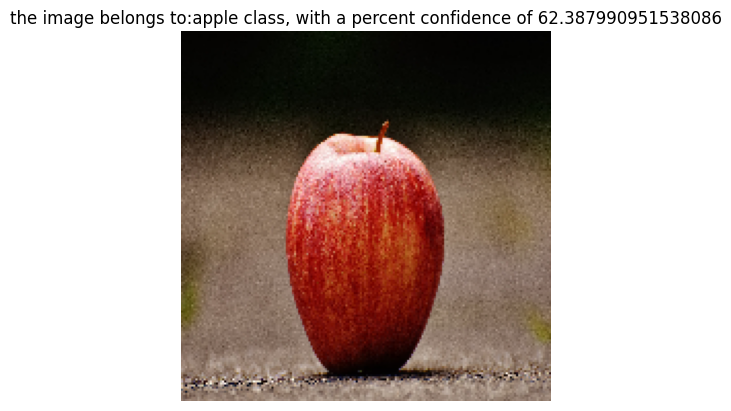

In [48]:
predict_image(model,'app.jpg')

In [ ]:
# Transfer learning

In [49]:
import tensorflow_hub as hub

In [50]:
model_url = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1")

In [50]:
efficientnet = hub.KerasLayer(model_url, trainable=False)

In [52]:
model_transfer = Sequential([
    efficientnet,
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [56]:
model_transfer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [57]:
transfer_history = model_transfer.fit(train_ds,validation_data=valid_ds,epochs=15)

Epoch 1/15
3/3 [==============================] - 13s 2s/step - loss: 1.0814 - accuracy: 0.4722 - val_loss: 1.1119 - val_accuracy: 0.2778
Epoch 2/15
3/3 [==============================] - 3s 928ms/step - loss: 1.0815 - accuracy: 0.4861 - val_loss: 1.1124 - val_accuracy: 0.2778
Epoch 3/15
3/3 [==============================] - 3s 904ms/step - loss: 1.0816 - accuracy: 0.4167 - val_loss: 1.1130 - val_accuracy: 0.2778
Epoch 4/15
3/3 [==============================] - 3s 1s/step - loss: 1.0796 - accuracy: 0.5278 - val_loss: 1.1136 - val_accuracy: 0.2778
Epoch 5/15
3/3 [==============================] - 3s 821ms/step - loss: 1.0713 - accuracy: 0.5556 - val_loss: 1.1140 - val_accuracy: 0.2778
Epoch 6/15
3/3 [==============================] - 2s 826ms/step - loss: 1.0749 - accuracy: 0.5000 - val_loss: 1.1146 - val_accuracy: 0.2778
Epoch 7/15
3/3 [==============================] - 2s 778ms/step - loss: 1.0775 - accuracy: 0.4583 - val_loss: 1.1151 - val_accuracy: 0.2778
Epoch 8/15
3/3 [=========

1/1 [==============================] - 0s 195ms/step


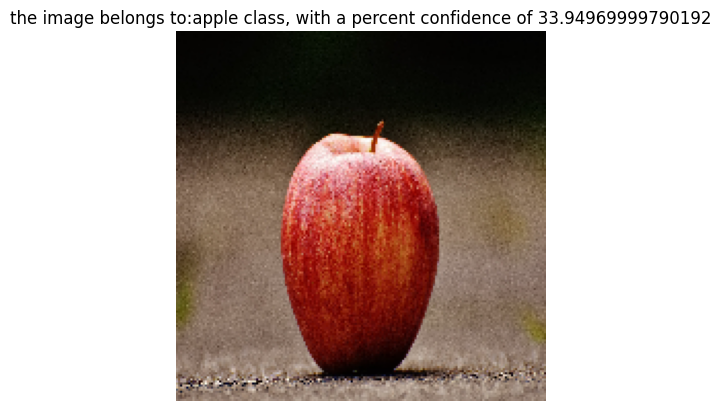

In [61]:
predict_image(model_transfer,'app.jpg')